In [1]:
import HeST as hest
import HeST.Amherst_Example_Detector as examp
import numpy as np
import matplotlib.pyplot as plt

import astropy.stats as astat

# Load the example detector based on the Amherst cell

In [2]:
detector = examp.DetectorExample_Amherst

## Use the WIMP Generator to create an energy spectrum, and compare to a flat ER signal.
### Generate quanta, and then convert the total number of singlet photons and quasiparticles into observable pulse areas, in eV.

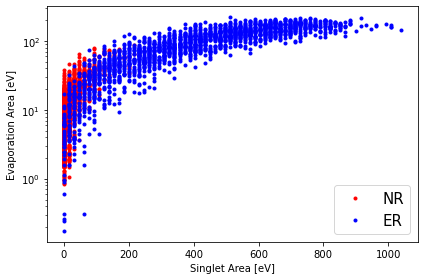

In [3]:

#create a WIMP energy spectrum!
spectrum_WIMP = []
mass = 5000 # MeV
nEvents = 2000

prep = hest.WIMP_spectrum_prep(mass)
for i in range(nEvents):
    spectrum_WIMP.append( hest.WIMP_spectrum(mass, *prep) )
    

spectrum_BG = np.random.uniform(20, 10000, size=nEvents) #20eV to 10keV


nrSinglet, nrTriplet, nrQP = [], [], []
erSinglet, erTriplet, erQP = [], [], []
for i in range(nEvents):
    q = hest.GetQuanta(spectrum_WIMP[i], "NR")
    sig = hest.GetSingletSignal(detector, q.SingletPhotons, 0, 0, 1)
    evap = hest.GetEvaporationSignal( detector, q.Quasiparticles, 0, 0, 1)
    nrSinglet.append( sig.area_eV )
    nrQP.append( evap.area_eV )
    
    q = hest.GetQuanta(spectrum_BG[i], "ER")
    sig = hest.GetSingletSignal(detector, q.SingletPhotons, 0, 0, 1)
    evap = hest.GetEvaporationSignal( detector, q.Quasiparticles, 0, 0, 1)
    erSinglet.append( sig.area_eV )
    erQP.append( evap.area_eV )
    
    
nrSinglet, nrTriplet, nrQP = np.array(nrSinglet), np.array(nrTriplet), np.array(nrQP)
erSinglet, erTriplet, erQP = np.array(erSinglet), np.array(erTriplet), np.array(erQP)

plt.plot( nrSinglet, nrQP, 'r o', ms=3, label='NR')
plt.plot( erSinglet, erQP, 'b o', ms=3, label='ER')

plt.xlabel('Singlet Area [eV]')
plt.ylabel('Evaporation Area [eV]')
#plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.legend(loc='best', fontsize=15)
plt.show()

110 photons, 2137819 QPs
356.5 [356.5] 1 23
93.258 [356.5] 1 15543


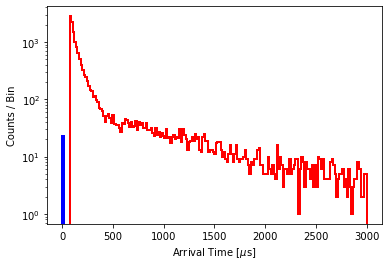

CPU times: user 3min 25s, sys: 19.4 ms, total: 3min 25s
Wall time: 3min 26s


In [4]:
%%time
#Look at arrival times of photons and QPs!

energy = 5500 #eV
q = hest.GetQuanta(energy, "ER")

print("%i photons, %i QPs" % (q.SingletPhotons, q.Quasiparticles))

pos = [0., 0., 1.5]
useMap = False
sig = hest.GetSingletSignal(detector, q.SingletPhotons, *pos, useMap=useMap)
print( sig.area_eV, sig.chArea_eV, sig.coincidence, len(sig.arrivalTimes_us))
evap = hest.GetEvaporationSignal( detector, q.Quasiparticles, *pos, useMap=useMap)
print( evap.area_eV, sig.chArea_eV, sig.coincidence, len(evap.arrivalTimes_us))


plt.hist(sig.arrivalTimes_us, bins=200, range=[0, 3000], histtype='step', color='b', lw=2)
plt.hist(evap.arrivalTimes_us, bins=200, range=[0, 3000], histtype='step', color='r', lw=2)
plt.yscale('log')
plt.xlabel(r'Arrival Time [$\mu$s]')
plt.ylabel('Counts / Bin')
plt.show()


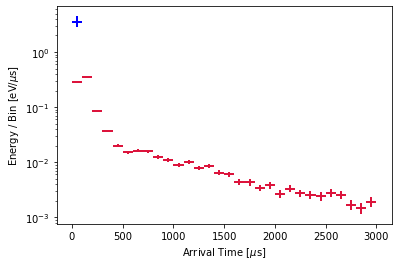

In [5]:
#normalize the arrival time histograms to total pulse area

bins = 30
lims = [0, 3000]

#create the histogram
histY, histX = np.histogram(sig.arrivalTimes_us, bins=bins, range=lims)
binCenters = np.array([np.mean([histX[i], histX[i+1]]) for i in range(len(histY))])
binSize = binCenters[1]-binCenters[0]
histN = sum(histY)
#get actual poisson error bars per bin, not just root-N
histErrLo, histErrHi = astat.poisson_conf_interval(histY, interval='frequentist-confidence', sigma=1)
histErrLo = histY - histErrLo
histErrHi = histErrHi - histY

#normalize to pulse area
histY = histY / histN / binSize   * sig.area_eV
histErrLo = histErrLo / histN / binSize * sig.area_eV
histErrHi = histErrHi / histN / binSize * sig.area_eV

plot_cut = (histY > 0.)
plt.errorbar( binCenters[plot_cut], histY[plot_cut], xerr=binSize/2., yerr=[histErrLo[plot_cut], histErrHi[plot_cut]], color='blue', lw=2, markersize=0, linestyle='none')

histY, histX = np.histogram(evap.arrivalTimes_us, bins=bins, range=lims)
binCenters = np.array([np.mean([histX[i], histX[i+1]]) for i in range(len(histY))])
binSize = binCenters[1]-binCenters[0]
histN = sum(histY)

#get actual poisson error bars per bin, not just root-N
histErrLo, histErrHi = astat.poisson_conf_interval(histY, interval='frequentist-confidence', sigma=1)
histErrLo = histY - histErrLo
histErrHi = histErrHi - histY

#normalize to pulse area
histY = histY / histN / binSize * evap.area_eV
histErrLo = histErrLo / histN / binSize * evap.area_eV
histErrHi = histErrHi / histN / binSize * evap.area_eV

plot_cut = (histY > 0.)
plt.errorbar( binCenters[plot_cut], histY[plot_cut], xerr=binSize/2., yerr=[histErrLo[plot_cut], histErrHi[plot_cut]], color='crimson', lw=2, markersize=0, linestyle='none')

plt.yscale('log')
plt.xlabel(r'Arrival Time [$\mu$s]')
plt.ylabel(r'Energy / Bin [eV/$\mu$s]')
plt.show()
